In [98]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.integrate import trapezoid, solve_ivp

In [99]:
# Curva real do fabricante
B_dados = np.array([0, 0.2, 0.6, 0.7, 0.75, 0.8, 0.85, 0.96,
                    1.02, 1.05, 1.08, 1.11, 1.13, 1.15, 1.18, 1.2])

H_dados = np.array([-50200, -49500, -48000, -47000, -46000,
                    -45000, -44000, -40000, -35000,
                    -30000, -25000, -20000, -15000,
                    -10000, -5000, 0])

In [100]:
# Dimensões
g0 = 1e-3
W  = 4e-2
D  = 3.5e-2
d  = 8e-3

# Bobina
N1 = 1000

# Constante magnética
U0 = 4*np.pi*1e-7

# Área
Area = W * D

num_pontos = 200

In [101]:
# Interpolação real
f_real = CubicSpline(B_dados, H_dados, bc_type='natural')

# Aproximação linear (reta entre extremos)
B_linear = np.array([0.0, 1.2])
H_linear = np.array([-50200.0, 0.0])
f_linear = CubicSpline(B_linear, H_linear, bc_type='natural')

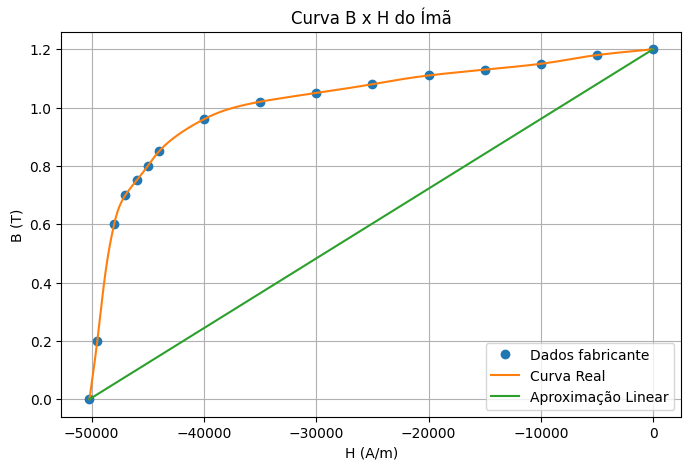

In [111]:
B_plot = np.linspace(np.min(B_dados), np.max(B_dados), num_pontos)
H_real_plot = f_real(B_plot)
H_linear_plot = f_linear(B_plot)

plt.figure(figsize=(8,5))
plt.plot(H_dados, B_dados, 'o', label="Dados fabricante")
plt.plot(H_real_plot, B_plot, label="Curva Real")
plt.plot(H_linear_plot, B_plot, label="Aproximação Linear")
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")
plt.title("Curva B x H do Ímã")
plt.legend()
plt.grid(True)
plt.show()

In [106]:
def Coenergia_forca(interpolacao_H_B, Nf):
    
    x = np.linspace(0, 0.02, num_pontos)   # 0 → 20 mm
    Bm = np.linspace(0, 1.2, num_pontos)
    
    If = np.zeros(num_pontos)
    lambda_concat = np.zeros(num_pontos)
    Coenergia = np.zeros(num_pontos)
    CoenergiaN1000 = np.zeros(num_pontos)

    Bm_x = None
    If_x = None

    for j in range(len(x)):
        
        for b in range(len(Bm)):
            
            # Corrente equivalente
            If[b] = ((interpolacao_H_B(Bm[b])*d) + 
                     (Bm[b]*(x[j] + g0)/U0)) / Nf
            
            lambda_concat[b] = Nf * Bm[b] * Area

        # Guardar dados em x = 0.5 mm
        indice_05mm = np.argmin(np.abs(x - 0.0005))

        if j == indice_05mm:
            Bm_x = np.copy(Bm)
            If_x = np.copy(If)

        interp_lambda_If = CubicSpline(If, lambda_concat)
        interp_If_Bm     = CubicSpline(Bm, If)

        If_0 = interp_If_Bm(0)

        I_int = np.linspace(If_0, 0, num_pontos)
        lam_int = interp_lambda_If(I_int)
        Coenergia[j] = trapezoid(lam_int, I_int)

        # Ponto normal fixado do fabricante
        Bop_normal = 1.08
        Hop_normal = -31.14e3
        xop_normal = 0.5e-3

        Iop_normal = ((-Hop_normal*d) + 
                      Bop_normal*((xop_normal + g0)/U0)) / Nf

        I_int_op = np.linspace(If_0, Iop_normal, num_pontos)
        lam_int_op = interp_lambda_If(I_int_op)
        CoenergiaN1000[j] = trapezoid(lam_int_op, I_int_op)

    if Nf == 1000:
        Forca = np.gradient(CoenergiaN1000[:-1], x[:-1])
        return Forca, CoenergiaN1000[:-1], x[:-1], Bm_x, If_x, Iop_normal
    else:
        Forca = np.gradient(Coenergia[:-1], x[:-1])
        return Forca, Coenergia[:-1], x[:-1]

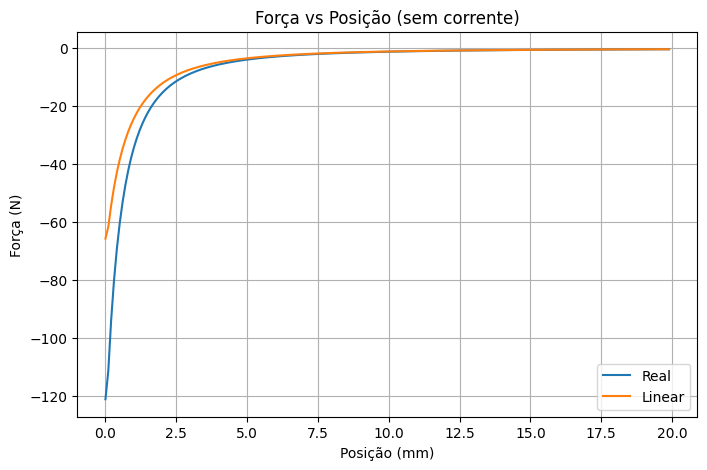

In [104]:

Forca_real_0, Co_real_0, posicao = Coenergia_forca(f_real, 1)
Forca_lin_0,  Co_lin_0,  posicao = Coenergia_forca(f_linear, 1)

plt.figure(figsize=(8,5))
plt.plot(posicao*1000, Forca_real_0, label="Real")
plt.plot(posicao*1000, Forca_lin_0, label="Linear")
plt.xlabel("Posição (mm)")
plt.ylabel("Força (N)")
plt.title("Força vs Posição (sem corrente)")
plt.legend()
plt.grid(True)
plt.show()

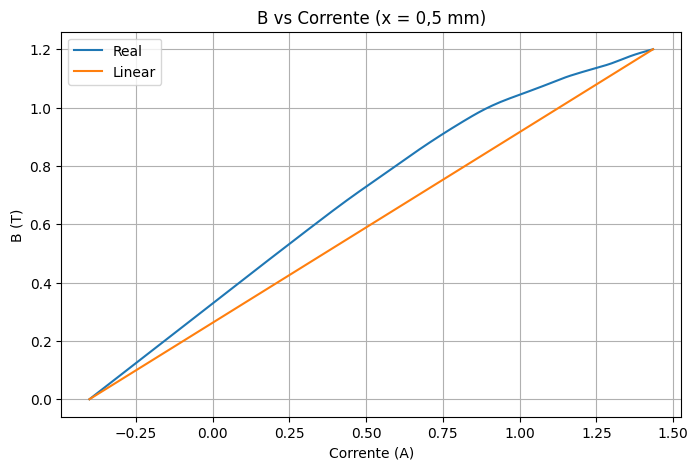

Corrente normal: 1.5382750390443525


In [107]:
Forca_real_i, Co_real_i, posicao_i, Bm_real, If_real, I_normal = Coenergia_forca(f_real, 1000)
Forca_lin_i,  Co_lin_i,  posicao_i, Bm_lin,  If_lin, _ = Coenergia_forca(f_linear, 1000)

plt.figure(figsize=(8,5))
plt.plot(If_real, Bm_real, label="Real")
plt.plot(If_lin, Bm_lin, label="Linear")
plt.xlabel("Corrente (A)")
plt.ylabel("B (T)")
plt.title("B vs Corrente (x = 0,5 mm)")
plt.legend()
plt.grid(True)
plt.show()

print("Corrente normal:", I_normal)

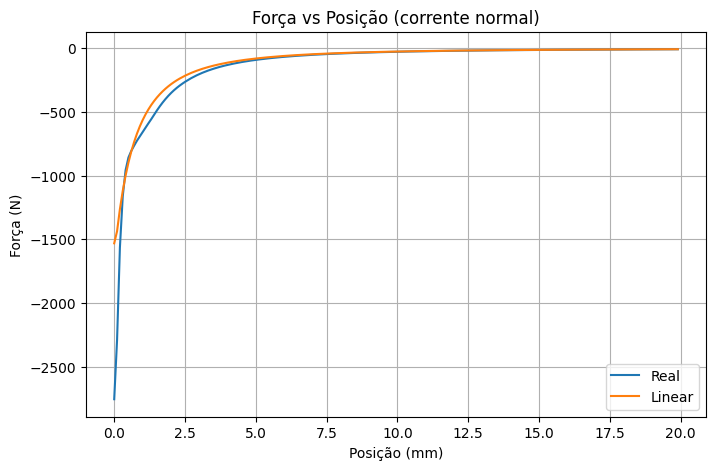

In [108]:
plt.figure(figsize=(8,5))
plt.plot(posicao_i*1000, Forca_real_i, label="Real")
plt.plot(posicao_i*1000, Forca_lin_i, label="Linear")
plt.xlabel("Posição (mm)")
plt.ylabel("Força (N)")
plt.title("Força vs Posição (corrente normal)")
plt.legend()
plt.grid(True)
plt.show()

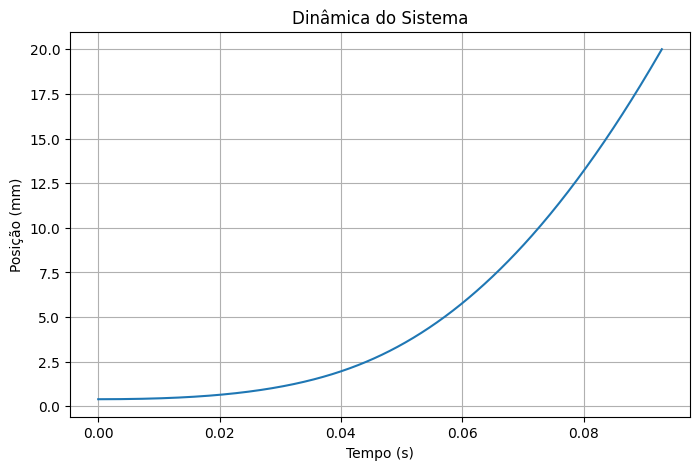

In [109]:
x_inicial = 0.0004
v_inicial = 0.0
y0 = [x_inicial, v_inicial]

forca_magnetica = CubicSpline(posicao_i, Forca_real_i)

forca_inicial = forca_magnetica(x_inicial)
massa_eq = abs(forca_inicial)/9.81
massa_real = 1.10 * massa_eq

def equacao_movimento(t, y):
    x, v = y
    Fm = abs(forca_magnetica(x))
    a = (Fm - massa_real*9.81)/massa_real
    return [-v, a]

def evento_parada(t, y):
    return y[0] - 0.02

evento_parada.terminal = True
evento_parada.direction = 1

sol = solve_ivp(equacao_movimento, (0,0.2), y0,
                events=evento_parada, dense_output=True)

t = np.linspace(sol.t[0], sol.t[-1], 500)
x_t = sol.sol(t)[0]

plt.figure(figsize=(8,5))
plt.plot(t, x_t*1000)
plt.xlabel("Tempo (s)")
plt.ylabel("Posição (mm)")
plt.title("Dinâmica do Sistema")
plt.grid(True)
plt.show()